In [223]:
import pandas as pd
import numpy as np
#import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization
import category_encoders as ce
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor

In [92]:
train = pd.read_csv(r'train.csv', index_col=0)
test = pd.read_csv(r'test.csv', index_col=0)

In [93]:
#metrica
def MAE(actual, pred):
    return (np.mean(np.absolute(actual - pred)))

## Preprocesamiento

In [94]:
train.isnull().sum()

titulo                          5387
descripcion                     1619
tipodepropiedad                   46
direccion                      53072
ciudad                           372
provincia                        155
antiguedad                     43555
habitaciones                   22471
garages                        37765
banos                          26221
metroscubiertos                17400
metrostotales                  51467
idzona                         28621
lat                           123488
lng                           123488
fecha                              0
gimnasio                           0
usosmultiples                      0
piscina                            0
escuelascercanas                   0
centroscomercialescercanos         0
precio                             0
dtype: int64

In [95]:
test.isnull().sum()

titulo                         1378
descripcion                     401
tipodepropiedad                   7
direccion                     13191
ciudad                           83
provincia                        42
antiguedad                    10714
habitaciones                   5628
garages                        9323
banos                          6554
metroscubiertos                4299
metrostotales                 12655
idzona                         7179
lat                           30695
lng                           30695
fecha                             0
gimnasio                          0
usosmultiples                     0
piscina                           0
escuelascercanas                  0
centroscomercialescercanos        0
dtype: int64

In [96]:
train['provincia'] = train['provincia'].fillna('Distrito Federal') #valor mas frecuente
test['provincia'] = test['provincia'].fillna('Distrito Federal')
train['tipodepropiedad'] = train['tipodepropiedad'].fillna('Casa') #valor mas frecuente
test['tipodepropiedad'] = test['tipodepropiedad'].fillna('Casa')

train['descripcion'] = train['descripcion'].fillna('-')
test['descripcion'] = test['descripcion'].fillna('-')

train = train.fillna(0)
test = test.fillna(0)

In [97]:
print(train.shape)
print(test.shape)

(240000, 22)
(60000, 21)


## Feature Engineering

### One Hot Encoding

In [98]:
one_hot_enc = ce.OneHotEncoder()
one_hot_encoded = one_hot_enc.fit_transform(train['provincia'])
train = train.join(one_hot_encoded)
del train['provincia']

one_hot_encoded = one_hot_enc.transform(test['provincia'])
test = test.join(one_hot_encoded)
del test['provincia']

In [99]:
one_hot_enc = ce.OneHotEncoder()
one_hot_encoded = one_hot_enc.fit_transform(train['tipodepropiedad'])
train = train.join(one_hot_encoded)
del train['tipodepropiedad']

one_hot_encoded = one_hot_enc.transform(test['tipodepropiedad'])
test = test.join(one_hot_encoded)
del test['tipodepropiedad']

### Target Encoding

In [100]:
print(train.shape)
print(test.shape)

(240000, 76)
(60000, 75)


In [101]:
X = train.drop('precio', axis = 1)
y = train['precio']
target_enc = ce.TargetEncoder(cols=['idzona', 'ciudad'])
train = target_enc.fit_transform(X, y)
train['precio'] = y

In [102]:
test = target_enc.transform(test)

In [103]:
print(train.shape)
print(test.shape)

(240000, 76)
(60000, 75)


### Agregando Features

#### Avenida

In [104]:
def avenida(st):
    return ("av." in st) or ("avenida" in st) or  ("av " in st)

In [105]:
test = test.astype({"direccion":"str"})
train = train.astype({"direccion":"str"})

test["direccion"] = test["direccion"].apply(str.lower)
test["avenida"] = test["direccion"].map(avenida)

train["direccion"] = train["direccion"].apply(str.lower)
train["avenida"] = train["direccion"].map(avenida)

test = test.astype({"avenida":"uint8"})
train = train.astype({"avenida":"uint8"})

#### Cantidad de amenities

In [106]:
train['cant_amenities'] = train['usosmultiples'] + train['piscina'] + train['gimnasio']
test['cant_amenities'] = test['usosmultiples'] + test['piscina'] + test['gimnasio']

#### Año de publicación

In [107]:
train['fecha'] = pd.to_datetime(train['fecha'])
train['ano'] = train['fecha'].dt.year

test['fecha'] = pd.to_datetime(test['fecha'])
test['ano'] = test['fecha'].dt.year

#### De la descripción

In [108]:
buena_ubicacion = ['buena ubicacion', 'buena ubicación', 'excelente ubicación', 'excelente ubicacion', 'bien ubicada', 'bien ubicado']
train['buena_ubicacion'] = train['descripcion'].apply(lambda x: 1 if any(word in x for word in buena_ubicacion ) else 0)
test['buena_ubicacion'] = test['descripcion'].apply(lambda x: 1 if any(word in x for word in buena_ubicacion ) else 0)

In [109]:
luminoso = ['luminoso', 'luminosa']
train['luminoso'] = train['descripcion'].apply(lambda x: 1 if any(word in x for word in luminoso ) else 0)
test['luminoso'] = test['descripcion'].apply(lambda x: 1 if any(word in x for word in luminoso ) else 0)

In [110]:
jardin = ['jardin', 'jardín', 'parque', 'patio']
train['jardin'] = train['descripcion'].apply(lambda x: 1 if any(word in x for word in luminoso ) else 0)
test['jardin'] = test['descripcion'].apply(lambda x: 1 if any(word in x for word in luminoso ) else 0)

In [111]:
balcon = ['balcon', 'balcón', 'terraza']
train['balcon'] = train['descripcion'].apply(lambda x: 1 if any(word in x for word in luminoso ) else 0)
test['balcon'] = test['descripcion'].apply(lambda x: 1 if any(word in x for word in luminoso ) else 0)

#### Cercanías

In [112]:
train['centroscomercialescercanos'] = train['centroscomercialescercanos'].map({1:2, 0:0})
test['centroscomercialescercanos'] = test['centroscomercialescercanos'].map({1:2, 0:0})

In [113]:
train['cercanias'] = train['centroscomercialescercanos'] + train['escuelascercanas']
train['cercanias'] = train['cercanias'].astype(str)

test['cercanias'] = test['centroscomercialescercanos'] + test['escuelascercanas']
test['cercanias'] = test['cercanias'].astype(str)

In [114]:
train = train.join(pd.get_dummies(train['cercanias'], prefix = 'cercania'))
del train['cercanias']

test = test.join(pd.get_dummies(test['cercanias'], prefix = 'cercania'))
del test['cercanias']

### Borrando columnas innecesarias

In [115]:
del train['lat']
del train['lng']
del train['descripcion']
del train['titulo']
del train['direccion']
del train['fecha']

del test['lat']
del test['lng']
del test['descripcion']
del test['titulo']
del test['direccion']
del test['fecha']

In [116]:
print(train.shape)
print(test.shape)

(240000, 81)
(60000, 80)


### Dividiendo por año

In [117]:
train_2012 = train[train['ano'] == 2012]
train_2013 = train[train['ano'] == 2013]
train_2014 = train[train['ano'] == 2014]
train_2015 = train[train['ano'] == 2015]
train_2016 = train[train['ano'] == 2016]

test_2012 = test[test['ano'] == 2012]
test_2013 = test[test['ano'] == 2013]
test_2014 = test[test['ano'] == 2014]
test_2015 = test[test['ano'] == 2015]
test_2016 = test[test['ano'] == 2016]

## KNN

In [118]:
def KNN(train, param_grid):
    KNN = KNeighborsRegressor()
    X = train.drop(['precio'], axis=1)
    y = train['precio']
    grid = RandomizedSearchCV(KNN, param_grid, cv=5, scoring='neg_mean_absolute_error')
    grid.fit(X, y)
    KNN = grid.best_estimator_
    print(grid.best_params_)
    print(grid.best_score_)
    return KNN

In [119]:
k_valores = list(range(1000, 1100))
param_grid = dict(n_neighbors=k_valores)
KNN_2012 = KNN(train_2012, param_grid)
KNN_2013 = KNN(train_2013, param_grid)
KNN_2014 = KNN(train_2014, param_grid)
KNN_2015 = KNN(train_2015, param_grid)
KNN_2016 = KNN(train_2016, param_grid)

{'n_neighbors': 1019}
-895044.1554332726
{'n_neighbors': 1000}
-843143.7218726056
{'n_neighbors': 1002}
-941446.6852549951
{'n_neighbors': 1018}
-995635.9135645042
{'n_neighbors': 1000}
-1043076.1465007125


In [120]:
from joblib import dump, load
dump(KNN_2012,'knn_2012.joblib')
dump(KNN_2013,'knn_2013.joblib')
dump(KNN_2014,'knn_2014.joblib')
dump(KNN_2015,'knn_2015.joblib')
dump(KNN_2016,'knn_2016.joblib')

['knn_2016.joblib']

In [121]:
knn_predict_2012 = KNN_2012.predict(test_2012)
knn_predict_2013 = KNN_2013.predict(test_2013)
knn_predict_2014 = KNN_2014.predict(test_2014)
knn_predict_2015 = KNN_2015.predict(test_2015)
knn_predict_2016 = KNN_2016.predict(test_2016)

## Definiendo tamaños de los sets

In [122]:
def train_set(train,test):
    X = train.drop(['precio'], axis=1)
    y = train['precio']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)
    print("Train shapes: X = " + str(X_train.shape) + " y = " + str(y_train.shape))
    print("Validation shapes: X = " + str(X_val.shape) +  " y = " + str(y_val.shape))
    print("Test shape: " + str(test.shape))
    return X, y, X_val, y_val

In [123]:
x_2012, y_2012, x_2012_val, y_2012_val = train_set(train_2012,test_2012)
x_2013, y_2013, x_2013_val, y_2013_val = train_set(train_2013,test_2013)
x_2014, y_2014, x_2014_val, y_2014_val = train_set(train_2014,test_2014)
x_2015, y_2015, x_2015_val, y_2015_val = train_set(train_2015,test_2015)
x_2016, y_2016, x_2016_val, y_2016_val = train_set(train_2016,test_2016)

Train shapes: X = (17650, 80) y = (17650,)
Validation shapes: X = (5884, 80) y = (5884,)
Test shape: (5899, 80)
Train shapes: X = (22789, 80) y = (22789,)
Validation shapes: X = (7597, 80) y = (7597,)
Test shape: (7592, 80)
Train shapes: X = (30429, 80) y = (30429,)
Validation shapes: X = (10143, 80) y = (10143,)
Test shape: (10018, 80)
Train shapes: X = (38602, 80) y = (38602,)
Validation shapes: X = (12868, 80) y = (12868,)
Test shape: (13017, 80)
Train shapes: X = (70528, 80) y = (70528,)
Validation shapes: X = (23510, 80) y = (23510,)
Test shape: (23474, 80)


## LIGHTGBM

### Tuneo de hiperparámetros

In [124]:
import lightgbm
def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, min_child_weight, learning_rate, seed,n_estimators):
    params = {}
    params['metric'] = 'rmse'
    params["seed"] = int(seed)
    params["learning_rate"] = learning_rate
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    params["n_estimators"] = int(n_estimators)
    cv_result = lightgbm.cv(params, dtrain, nfold=5, num_boost_round=100)
    # Used around 1000 boosting rounds in the full model
    #cv_result = lightgbm.cv(params, dtrain, num_boost_round=100, nfold=3, seed=20)    
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return max(cv_result['rmse-mean'])

In [125]:
def optimize_lgbm(sett):
    dtrain = sett
    lightgbm_bo = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
                                        'feature_fraction': (0.1, 0.9),
                                        'bagging_fraction': (0.8, 1),
                                        'max_depth': (5, 9),
                                        'min_split_gain': (0.001, 0.1),
                                        'min_child_weight': (5, 50),
                                        "learning_rate" : (0.01, 0.07),
                                        "seed":(10,50),
                                        "n_estimators":(1000,10000)          
                                        }, random_state=0)
    # Se probo con 3 puntos iniciales y 10 iteraciones, deberiamos probar con mas en ambas
    # La prox iteracion en casa probar 100 y 10000
    lightgbm_bo.maximize(init_points=5, n_iter=30, acq='ei')
    params = lightgbm_bo.max['params']
    params['max_depth'] = int(params['max_depth'])
    params["seed"] = int(params["seed"])
    params["n_estimators"] = int(params["n_estimators"])
    return params

In [126]:
feature_set = list(x_2012.columns)
dtrain_2012 = lightgbm.Dataset(x_2012, label=y_2012,feature_name=feature_set)
feature_set = list(x_2013.columns)
dtrain_2013 = lightgbm.Dataset(x_2013, label=y_2013,feature_name=feature_set)
feature_set = list(x_2014.columns)
dtrain_2014 = lightgbm.Dataset(x_2014, label=y_2014,feature_name=feature_set)
feature_set = list(x_2015.columns)
dtrain_2015 = lightgbm.Dataset(x_2015, label=y_2015,feature_name=feature_set)
feature_set = list(x_2016.columns)
dtrain_2016 = lightgbm.Dataset(x_2016, label=y_2016,feature_name=feature_set)


In [127]:
dtrain = dtrain_2012
params_2012 = optimize_lgbm(dtrain_2012)
dtrain = dtrain_2013
params_2013 = optimize_lgbm(dtrain_2013)
dtrain = dtrain_2014
params_2014 = optimize_lgbm(dtrain_2014)
dtrain = dtrain_2015
params_2015 = optimize_lgbm(dtrain_2015)
dtrain = dtrain_2016
params_2016 = optimize_lgbm(dtrain_2016)

|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | min_sp... | n_esti... | num_le... |   seed    |
-------------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  1        |  1.727e+0 |  0.9098   |  0.6722   |  0.04617  |  7.18     |  24.06    |  0.06494  |  4.938e+0 |  42.73    |  48.55    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  2        |  1.739e+0 |  0.8767   |  0.7334   |  0.04173  |  7.272    |  46.65    |  0.008033 |  1.784e+0 |  24.42    |  43.3     |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  3        |  1.702e+0 |  0.9556   |  0.796    |  0.06872  |  8.197    |  25.77    |  0.07827  |  2.064e+0 |  37.44    |  15.73    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  4        |  1.748e+0 |  0.9889   |  0.5175   |  0.03488  |  6.058    |  39.84    |  0.04616  |  6.116e+0 |  24.39    |  34.71    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  5        |  1.716e+0 |  0.9224   |  0.5935   |  0.06662  |  7.727    |  21.18    |  0.04427  |  7.279e+0 |  25.26    |  36.67    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  6        |  1.772e+0 |  0.8844   |  0.2402   |  0.01921  |  8.233    |  9.211    |  0.001068 |  7.493e+0 |  30.28    |  39.33    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  7        |  1.761e+0 |  0.8595   |  0.843    |  0.01736  |  5.97     |  23.52    |  0.03308  |  6.152e+0 |  28.82    |  47.88    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  8        |  1.755e+0 |  0.9116   |  0.6652   |  0.0291   |  6.537    |  18.14    |  0.06617  |  6.098e+0 |  29.32    |  45.58    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  9        |  1.711e+0 |  0.9396   |  0.2106   |  0.06445  |  7.5      |  34.7     |  0.06542  |  6.628e+0 |  28.8     |  36.39    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  10       |  1.722e+0 |  0.9603   |  0.865    |  0.05059  |  6.629    |  21.06    |  0.02608  |  1.416e+0 |  36.43    |  18.61    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  11       |  1.713e+0 |  0.9577   |  0.6611   |  0.05888  |  7.256    |  41.3     |  0.07923  |  8.368e+0 |  32.23    |  37.26    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  12       |  1.758e+0 |  0.8575   |  0.2975   |  0.03868  |  5.399    |  40.28    |  0.09882  |  1.793e+0 |  25.36    |  38.65    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  13       |  1.759e+0 |  0.951    |  0.6561   |  0.02132  |  8.983    |  41.21    |  0.04594  |  2.894e+0 |  26.45    |  28.42    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  14       |  1.766e+0 |  0.8457   |  0.4622   |  0.01581  |  6.113    |  28.36    |  0.05396  |  7.54e+03 |  38.65    |  44.3     |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  15       |  1.73e+06 |  0.853    |  0.4545   |  0.0522   |  5.428    |  38.43    |  0.001316 |  1.039e+0 |  33.05    |  13.05    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  16       |  1.764e+0 |  0.9359   |  0.8724   |  0.01431  |  7.418    |  8.735    |  0.09379  |  5.814e+0 |  40.16    |  20.37    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  17       |  1.738e+0 |  0.9979   |  0.6439   |  0.03786  |  6.076    |  37.62    |  0.09645  |  7.331e+0 |  32.11    |  10.71    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  18       |  1.759e+0 |  0.9918   |  0.2612   |  0.02321  |  5.548    |  9.812    |  0.09498  |  9.729e+0 |  38.44    |  30.16    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  19       |  1.744e+0 |  0.8746   |  0.249    |  0.05375  |  8.143    |  33.56    |  0.04833  |  9.382e+0 |  26.39    |  23.5     |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  20       |  1.759e+0 |  0.8393   |  0.2402   |  0.03154  |  7.113    |  28.48    |  0.02748  |  5.279e+0 |  30.63    |  48.16    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  21       |  1.74e+06 |  0.9968   |  0.8276   |  0.03609  |  5.922    |  15.33    |  0.03068  |  6.304e+0 |  33.36    |  28.39    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  22       |  1.737e+0 |  0.9065   |  0.3233   |  0.04655  |  7.683    |  16.72    |  0.03542  |  5.198e+0 |  28.84    |  16.14    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  23       |  1.743e+0 |  0.832    |  0.2657   |  0.04303  |  7.612    |  31.18    |  0.05258  |  8.944e+0 |  33.68    |  40.89    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  24       |  1.718e+0 |  0.919    |  0.655    |  0.06459  |  7.205    |  39.19    |  0.01897  |  4.244e+0 |  30.96    |  36.63    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  25       |  1.706e+0 |  0.8768   |  0.8819   |  0.06463  |  8.151    |  43.29    |  0.02874  |  9.494e+0 |  41.24    |  10.5     |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  26       |  1.713e+0 |  0.9563   |  0.4007   |  0.06042  |  7.337    |  49.21    |  0.08541  |  9.293e+0 |  24.31    |  46.22    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  27       |  1.748e+0 |  0.9814   |  0.6478   |  0.02909  |  7.59     |  37.88    |  0.04443  |  2.525e+0 |  29.46    |  24.38    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  28       |  1.722e+0 |  0.8901   |  0.8498   |  0.05063  |  7.725    |  42.41    |  0.05489  |  6.083e+0 |  32.77    |  28.04    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  29       |  1.752e+0 |  0.8423   |  0.7492   |  0.02448  |  7.032    |  24.97    |  0.007552 |  9.112e+0 |  38.93    |  41.7     |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  30       |  1.737e+0 |  0.9238   |  0.7257   |  0.0468   |  7.539    |  43.56    |  0.09135  |  5.11e+03 |  27.45    |  19.34    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  31       |  1.75e+06 |  0.8325   |  0.6997   |  0.03203  |  7.334    |  45.26    |  0.09881  |  7.108e+0 |  40.25    |  44.54    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  32       |  1.757e+0 |  0.9399   |  0.6704   |  0.02016  |  7.627    |  46.03    |  0.07006  |  5.124e+0 |  42.86    |  15.52    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  33       |  1.762e+0 |  0.9433   |  0.4372   |  0.01855  |  5.133    |  31.74    |  0.03462  |  2.67e+03 |  30.08    |  13.98    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  34       |  1.746e+0 |  0.9168   |  0.3403   |  0.03923  |  6.606    |  48.22    |  0.07475  |  4.257e+0 |  34.42    |  47.41    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  35       |  1.726e+0 |  0.9534   |  0.2989   |  0.06107  |  7.595    |  9.873    |  0.09793  |  9.003e+0 |  35.12    |  32.44    |
|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | min_sp... | n_esti... | num_le... |   seed    |
-------------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  1        |  1.787e+0 |  0.9098   |  0.6722   |  0.04617  |  7.18     |  24.06    |  0.06494  |  4.938e+0 |  42.73    |  48.55    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  2        |  1.801e+0 |  0.8767   |  0.7334   |  0.04173  |  7.272    |  46.65    |  0.008033 |  1.784e+0 |  24.42    |  43.3     |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  3        |  1.76e+06 |  0.9556   |  0.796    |  0.06872  |  8.197    |  25.77    |  0.07827  |  2.064e+0 |  37.44    |  15.73    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  4        |  1.813e+0 |  0.9889   |  0.5175   |  0.03488  |  6.058    |  39.84    |  0.04616  |  6.116e+0 |  24.39    |  34.71    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  5        |  1.783e+0 |  0.9224   |  0.5935   |  0.06662  |  7.727    |  21.18    |  0.04427  |  7.279e+0 |  25.26    |  36.67    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  6        |  1.839e+0 |  0.8844   |  0.2402   |  0.01921  |  8.233    |  9.211    |  0.001068 |  7.493e+0 |  30.28    |  39.33    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  7        |  1.826e+0 |  0.8595   |  0.843    |  0.01736  |  5.97     |  23.52    |  0.03308  |  6.152e+0 |  28.82    |  47.88    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  8        |  1.819e+0 |  0.9116   |  0.6652   |  0.0291   |  6.537    |  18.14    |  0.06617  |  6.098e+0 |  29.32    |  45.58    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  9        |  1.768e+0 |  0.9396   |  0.2106   |  0.06445  |  7.5      |  34.7     |  0.06542  |  6.628e+0 |  28.8     |  36.39    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  10       |  1.783e+0 |  0.9603   |  0.865    |  0.05059  |  6.629    |  21.06    |  0.02608  |  1.416e+0 |  36.43    |  18.61    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  11       |  1.774e+0 |  0.9577   |  0.6611   |  0.05888  |  7.256    |  41.3     |  0.07923  |  8.368e+0 |  32.23    |  37.26    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  12       |  1.826e+0 |  0.8575   |  0.2975   |  0.03868  |  5.399    |  40.28    |  0.09882  |  1.793e+0 |  25.36    |  38.65    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  13       |  1.823e+0 |  0.951    |  0.6561   |  0.02132  |  8.983    |  41.21    |  0.04594  |  2.894e+0 |  26.45    |  28.42    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  14       |  1.83e+06 |  0.8457   |  0.4622   |  0.01581  |  6.113    |  28.36    |  0.05396  |  7.54e+03 |  38.65    |  44.3     |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  15       |  1.791e+0 |  0.853    |  0.4545   |  0.0522   |  5.428    |  38.43    |  0.001316 |  1.039e+0 |  33.05    |  13.05    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  16       |  1.829e+0 |  0.9359   |  0.8724   |  0.01431  |  7.418    |  8.735    |  0.09379  |  5.814e+0 |  40.16    |  20.37    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  17       |  1.802e+0 |  0.9979   |  0.6439   |  0.03786  |  6.076    |  37.62    |  0.09645  |  7.331e+0 |  32.11    |  10.71    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  18       |  1.824e+0 |  0.9918   |  0.2612   |  0.02321  |  5.548    |  9.812    |  0.09498  |  9.729e+0 |  38.44    |  30.16    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  19       |  1.805e+0 |  0.8746   |  0.249    |  0.05375  |  8.143    |  33.56    |  0.04833  |  9.382e+0 |  26.39    |  23.5     |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  20       |  1.825e+0 |  0.8393   |  0.2402   |  0.03154  |  7.113    |  28.48    |  0.02748  |  5.279e+0 |  30.63    |  48.16    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  21       |  1.802e+0 |  0.9968   |  0.8276   |  0.03609  |  5.922    |  15.33    |  0.03068  |  6.304e+0 |  33.36    |  28.39    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  22       |  1.802e+0 |  0.9065   |  0.3233   |  0.04655  |  7.683    |  16.72    |  0.03542  |  5.198e+0 |  28.84    |  16.14    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  23       |  1.8e+06  |  0.832    |  0.2657   |  0.04303  |  7.612    |  31.18    |  0.05258  |  8.944e+0 |  33.68    |  40.89    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  24       |  1.784e+0 |  0.919    |  0.655    |  0.06459  |  7.205    |  39.19    |  0.01897  |  4.244e+0 |  30.96    |  36.63    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  25       |  1.764e+0 |  0.8768   |  0.8819   |  0.06463  |  8.151    |  43.29    |  0.02874  |  9.494e+0 |  41.24    |  10.5     |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  26       |  1.775e+0 |  0.9563   |  0.4007   |  0.06042  |  7.337    |  49.21    |  0.08541  |  9.293e+0 |  24.31    |  46.22    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  27       |  1.811e+0 |  0.9814   |  0.6478   |  0.02909  |  7.59     |  37.88    |  0.04443  |  2.525e+0 |  29.46    |  24.38    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  28       |  1.783e+0 |  0.8901   |  0.8498   |  0.05063  |  7.725    |  42.41    |  0.05489  |  6.083e+0 |  32.77    |  28.04    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  29       |  1.816e+0 |  0.8423   |  0.7492   |  0.02448  |  7.032    |  24.97    |  0.007552 |  9.112e+0 |  38.93    |  41.7     |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  30       |  1.797e+0 |  0.9238   |  0.7257   |  0.0468   |  7.539    |  43.56    |  0.09135  |  5.11e+03 |  27.45    |  19.34    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  31       |  1.812e+0 |  0.8325   |  0.6997   |  0.03203  |  7.334    |  45.26    |  0.09881  |  7.108e+0 |  40.25    |  44.54    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  32       |  1.821e+0 |  0.9399   |  0.6704   |  0.02016  |  7.627    |  46.03    |  0.07006  |  5.124e+0 |  42.86    |  15.52    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  33       |  1.827e+0 |  0.9433   |  0.4372   |  0.01855  |  5.133    |  31.74    |  0.03462  |  2.67e+03 |  30.08    |  13.98    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  34       |  1.812e+0 |  0.9168   |  0.3403   |  0.03923  |  6.606    |  48.22    |  0.07475  |  4.257e+0 |  34.42    |  47.41    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  35       |  1.792e+0 |  0.9534   |  0.2989   |  0.06107  |  7.595    |  9.873    |  0.09793  |  9.003e+0 |  35.12    |  32.44    |
|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | min_sp... | n_esti... | num_le... |   seed    |
-------------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  1        |  1.921e+0 |  0.9098   |  0.6722   |  0.04617  |  7.18     |  24.06    |  0.06494  |  4.938e+0 |  42.73    |  48.55    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  2        |  1.934e+0 |  0.8767   |  0.7334   |  0.04173  |  7.272    |  46.65    |  0.008033 |  1.784e+0 |  24.42    |  43.3     |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  3        |  1.893e+0 |  0.9556   |  0.796    |  0.06872  |  8.197    |  25.77    |  0.07827  |  2.064e+0 |  37.44    |  15.73    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  4        |  1.947e+0 |  0.9889   |  0.5175   |  0.03488  |  6.058    |  39.84    |  0.04616  |  6.116e+0 |  24.39    |  34.71    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  5        |  1.913e+0 |  0.9224   |  0.5935   |  0.06662  |  7.727    |  21.18    |  0.04427  |  7.279e+0 |  25.26    |  36.67    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  6        |  1.98e+06 |  0.8844   |  0.2402   |  0.01921  |  8.233    |  9.211    |  0.001068 |  7.493e+0 |  30.28    |  39.33    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  7        |  1.959e+0 |  0.8595   |  0.843    |  0.01736  |  5.97     |  23.52    |  0.03308  |  6.152e+0 |  28.82    |  47.88    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  8        |  1.953e+0 |  0.9116   |  0.6652   |  0.0291   |  6.537    |  18.14    |  0.06617  |  6.098e+0 |  29.32    |  45.58    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  9        |  1.913e+0 |  0.9396   |  0.2106   |  0.06445  |  7.5      |  34.7     |  0.06542  |  6.628e+0 |  28.8     |  36.39    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  10       |  1.916e+0 |  0.9603   |  0.865    |  0.05059  |  6.629    |  21.06    |  0.02608  |  1.416e+0 |  36.43    |  18.61    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  11       |  1.907e+0 |  0.9577   |  0.6611   |  0.05888  |  7.256    |  41.3     |  0.07923  |  8.368e+0 |  32.23    |  37.26    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  12       |  1.956e+0 |  0.8575   |  0.2975   |  0.03868  |  5.399    |  40.28    |  0.09882  |  1.793e+0 |  25.36    |  38.65    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  13       |  1.956e+0 |  0.951    |  0.6561   |  0.02132  |  8.983    |  41.21    |  0.04594  |  2.894e+0 |  26.45    |  28.42    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  14       |  1.963e+0 |  0.8457   |  0.4622   |  0.01581  |  6.113    |  28.36    |  0.05396  |  7.54e+03 |  38.65    |  44.3     |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  15       |  1.921e+0 |  0.853    |  0.4545   |  0.0522   |  5.428    |  38.43    |  0.001316 |  1.039e+0 |  33.05    |  13.05    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  16       |  1.962e+0 |  0.9359   |  0.8724   |  0.01431  |  7.418    |  8.735    |  0.09379  |  5.814e+0 |  40.16    |  20.37    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  17       |  1.934e+0 |  0.9979   |  0.6439   |  0.03786  |  6.076    |  37.62    |  0.09645  |  7.331e+0 |  32.11    |  10.71    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  18       |  1.958e+0 |  0.9918   |  0.2612   |  0.02321  |  5.548    |  9.812    |  0.09498  |  9.729e+0 |  38.44    |  30.16    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  19       |  1.934e+0 |  0.8746   |  0.249    |  0.05375  |  8.143    |  33.56    |  0.04833  |  9.382e+0 |  26.39    |  23.5     |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  20       |  1.955e+0 |  0.8393   |  0.2402   |  0.03154  |  7.113    |  28.48    |  0.02748  |  5.279e+0 |  30.63    |  48.16    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  21       |  1.935e+0 |  0.9968   |  0.8276   |  0.03609  |  5.922    |  15.33    |  0.03068  |  6.304e+0 |  33.36    |  28.39    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  22       |  1.939e+0 |  0.9065   |  0.3233   |  0.04655  |  7.683    |  16.72    |  0.03542  |  5.198e+0 |  28.84    |  16.14    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  23       |  1.933e+0 |  0.832    |  0.2657   |  0.04303  |  7.612    |  31.18    |  0.05258  |  8.944e+0 |  33.68    |  40.89    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  24       |  1.914e+0 |  0.919    |  0.655    |  0.06459  |  7.205    |  39.19    |  0.01897  |  4.244e+0 |  30.96    |  36.63    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  25       |  1.897e+0 |  0.8768   |  0.8819   |  0.06463  |  8.151    |  43.29    |  0.02874  |  9.494e+0 |  41.24    |  10.5     |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  26       |  1.907e+0 |  0.9563   |  0.4007   |  0.06042  |  7.337    |  49.21    |  0.08541  |  9.293e+0 |  24.31    |  46.22    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  27       |  1.944e+0 |  0.9814   |  0.6478   |  0.02909  |  7.59     |  37.88    |  0.04443  |  2.525e+0 |  29.46    |  24.38    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  28       |  1.916e+0 |  0.8901   |  0.8498   |  0.05063  |  7.725    |  42.41    |  0.05489  |  6.083e+0 |  32.77    |  28.04    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  29       |  1.949e+0 |  0.8423   |  0.7492   |  0.02448  |  7.032    |  24.97    |  0.007552 |  9.112e+0 |  38.93    |  41.7     |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  30       |  1.929e+0 |  0.9238   |  0.7257   |  0.0468   |  7.539    |  43.56    |  0.09135  |  5.11e+03 |  27.45    |  19.34    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  31       |  1.944e+0 |  0.8325   |  0.6997   |  0.03203  |  7.334    |  45.26    |  0.09881  |  7.108e+0 |  40.25    |  44.54    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  32       |  1.954e+0 |  0.9399   |  0.6704   |  0.02016  |  7.627    |  46.03    |  0.07006  |  5.124e+0 |  42.86    |  15.52    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  33       |  1.96e+06 |  0.9433   |  0.4372   |  0.01855  |  5.133    |  31.74    |  0.03462  |  2.67e+03 |  30.08    |  13.98    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  34       |  1.943e+0 |  0.9168   |  0.3403   |  0.03923  |  6.606    |  48.22    |  0.07475  |  4.257e+0 |  34.42    |  47.41    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  35       |  1.923e+0 |  0.9534   |  0.2989   |  0.06107  |  7.595    |  9.873    |  0.09793  |  9.003e+0 |  35.12    |  32.44    |
|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | min_sp... | n_esti... | num_le... |   seed    |
-------------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  1        |  2.121e+0 |  0.9098   |  0.6722   |  0.04617  |  7.18     |  24.06    |  0.06494  |  4.938e+0 |  42.73    |  48.55    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  2        |  2.134e+0 |  0.8767   |  0.7334   |  0.04173  |  7.272    |  46.65    |  0.008033 |  1.784e+0 |  24.42    |  43.3     |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  3        |  2.089e+0 |  0.9556   |  0.796    |  0.06872  |  8.197    |  25.77    |  0.07827  |  2.064e+0 |  37.44    |  15.73    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  4        |  2.149e+0 |  0.9889   |  0.5175   |  0.03488  |  6.058    |  39.84    |  0.04616  |  6.116e+0 |  24.39    |  34.71    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  5        |  2.111e+0 |  0.9224   |  0.5935   |  0.06662  |  7.727    |  21.18    |  0.04427  |  7.279e+0 |  25.26    |  36.67    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  6        |  2.166e+0 |  0.8844   |  0.2402   |  0.01921  |  8.233    |  9.211    |  0.001068 |  7.493e+0 |  30.28    |  39.33    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  7        |  2.164e+0 |  0.8595   |  0.843    |  0.01736  |  5.97     |  23.52    |  0.03308  |  6.152e+0 |  28.82    |  47.88    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  8        |  2.154e+0 |  0.9116   |  0.6652   |  0.0291   |  6.537    |  18.14    |  0.06617  |  6.098e+0 |  29.32    |  45.58    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  9        |  2.146e+0 |  0.9396   |  0.2106   |  0.06445  |  7.5      |  34.7     |  0.06542  |  6.628e+0 |  28.8     |  36.39    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  10       |  2.116e+0 |  0.9603   |  0.865    |  0.05059  |  6.629    |  21.06    |  0.02608  |  1.416e+0 |  36.43    |  18.61    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  11       |  2.105e+0 |  0.9577   |  0.6611   |  0.05888  |  7.256    |  41.3     |  0.07923  |  8.368e+0 |  32.23    |  37.26    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  12       |  2.162e+0 |  0.8575   |  0.2975   |  0.03868  |  5.399    |  40.28    |  0.09882  |  1.793e+0 |  25.36    |  38.65    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  13       |  2.16e+06 |  0.951    |  0.6561   |  0.02132  |  8.983    |  41.21    |  0.04594  |  2.894e+0 |  26.45    |  28.42    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  14       |  2.168e+0 |  0.8457   |  0.4622   |  0.01581  |  6.113    |  28.36    |  0.05396  |  7.54e+03 |  38.65    |  44.3     |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  15       |  2.122e+0 |  0.853    |  0.4545   |  0.0522   |  5.428    |  38.43    |  0.001316 |  1.039e+0 |  33.05    |  13.05    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  16       |  2.168e+0 |  0.9359   |  0.8724   |  0.01431  |  7.418    |  8.735    |  0.09379  |  5.814e+0 |  40.16    |  20.37    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  17       |  2.136e+0 |  0.9979   |  0.6439   |  0.03786  |  6.076    |  37.62    |  0.09645  |  7.331e+0 |  32.11    |  10.71    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  18       |  2.163e+0 |  0.9918   |  0.2612   |  0.02321  |  5.548    |  9.812    |  0.09498  |  9.729e+0 |  38.44    |  30.16    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  19       |  2.114e+0 |  0.8746   |  0.249    |  0.05375  |  8.143    |  33.56    |  0.04833  |  9.382e+0 |  26.39    |  23.5     |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  20       |  2.165e+0 |  0.8393   |  0.2402   |  0.03154  |  7.113    |  28.48    |  0.02748  |  5.279e+0 |  30.63    |  48.16    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  21       |  2.137e+0 |  0.9968   |  0.8276   |  0.03609  |  5.922    |  15.33    |  0.03068  |  6.304e+0 |  33.36    |  28.39    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  22       |  2.135e+0 |  0.9065   |  0.3233   |  0.04655  |  7.683    |  16.72    |  0.03542  |  5.198e+0 |  28.84    |  16.14    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  23       |  2.132e+0 |  0.832    |  0.2657   |  0.04303  |  7.612    |  31.18    |  0.05258  |  8.944e+0 |  33.68    |  40.89    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  24       |  2.112e+0 |  0.919    |  0.655    |  0.06459  |  7.205    |  39.19    |  0.01897  |  4.244e+0 |  30.96    |  36.63    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  25       |  2.094e+0 |  0.8768   |  0.8819   |  0.06463  |  8.151    |  43.29    |  0.02874  |  9.494e+0 |  41.24    |  10.5     |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  26       |  2.105e+0 |  0.9563   |  0.4007   |  0.06042  |  7.337    |  49.21    |  0.08541  |  9.293e+0 |  24.31    |  46.22    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  27       |  2.147e+0 |  0.9814   |  0.6478   |  0.02909  |  7.59     |  37.88    |  0.04443  |  2.525e+0 |  29.46    |  24.38    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  28       |  2.116e+0 |  0.8901   |  0.8498   |  0.05063  |  7.725    |  42.41    |  0.05489  |  6.083e+0 |  32.77    |  28.04    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  29       |  2.153e+0 |  0.8423   |  0.7492   |  0.02448  |  7.032    |  24.97    |  0.007552 |  9.112e+0 |  38.93    |  41.7     |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  30       |  2.128e+0 |  0.9238   |  0.7257   |  0.0468   |  7.539    |  43.56    |  0.09135  |  5.11e+03 |  27.45    |  19.34    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  31       |  2.146e+0 |  0.8325   |  0.6997   |  0.03203  |  7.334    |  45.26    |  0.09881  |  7.108e+0 |  40.25    |  44.54    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  32       |  2.159e+0 |  0.9399   |  0.6704   |  0.02016  |  7.627    |  46.03    |  0.07006  |  5.124e+0 |  42.86    |  15.52    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  33       |  2.165e+0 |  0.9433   |  0.4372   |  0.01855  |  5.133    |  31.74    |  0.03462  |  2.67e+03 |  30.08    |  13.98    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  34       |  2.156e+0 |  0.9168   |  0.3403   |  0.03923  |  6.606    |  48.22    |  0.07475  |  4.257e+0 |  34.42    |  47.41    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  35       |  2.133e+0 |  0.9534   |  0.2989   |  0.06107  |  7.595    |  9.873    |  0.09793  |  9.003e+0 |  35.12    |  32.44    |
|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | min_sp... | n_esti... | num_le... |   seed    |
-------------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  1        |  2.254e+0 |  0.9098   |  0.6722   |  0.04617  |  7.18     |  24.06    |  0.06494  |  4.938e+0 |  42.73    |  48.55    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  2        |  2.267e+0 |  0.8767   |  0.7334   |  0.04173  |  7.272    |  46.65    |  0.008033 |  1.784e+0 |  24.42    |  43.3     |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  3        |  2.22e+06 |  0.9556   |  0.796    |  0.06872  |  8.197    |  25.77    |  0.07827  |  2.064e+0 |  37.44    |  15.73    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  4        |  2.284e+0 |  0.9889   |  0.5175   |  0.03488  |  6.058    |  39.84    |  0.04616  |  6.116e+0 |  24.39    |  34.71    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  5        |  2.26e+06 |  0.9224   |  0.5935   |  0.06662  |  7.727    |  21.18    |  0.04427  |  7.279e+0 |  25.26    |  36.67    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  6        |  2.313e+0 |  0.8844   |  0.2402   |  0.01921  |  8.233    |  9.211    |  0.001068 |  7.493e+0 |  30.28    |  39.33    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  7        |  2.299e+0 |  0.8595   |  0.843    |  0.01736  |  5.97     |  23.52    |  0.03308  |  6.152e+0 |  28.82    |  47.88    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  8        |  2.291e+0 |  0.9116   |  0.6652   |  0.0291   |  6.537    |  18.14    |  0.06617  |  6.098e+0 |  29.32    |  45.58    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  9        |  2.259e+0 |  0.9396   |  0.2106   |  0.06445  |  7.5      |  34.7     |  0.06542  |  6.628e+0 |  28.8     |  36.39    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  10       |  2.248e+0 |  0.9603   |  0.865    |  0.05059  |  6.629    |  21.06    |  0.02608  |  1.416e+0 |  36.43    |  18.61    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  11       |  2.237e+0 |  0.9577   |  0.6611   |  0.05888  |  7.256    |  41.3     |  0.07923  |  8.368e+0 |  32.23    |  37.26    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  12       |  2.297e+0 |  0.8575   |  0.2975   |  0.03868  |  5.399    |  40.28    |  0.09882  |  1.793e+0 |  25.36    |  38.65    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  13       |  2.295e+0 |  0.951    |  0.6561   |  0.02132  |  8.983    |  41.21    |  0.04594  |  2.894e+0 |  26.45    |  28.42    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  14       |  2.303e+0 |  0.8457   |  0.4622   |  0.01581  |  6.113    |  28.36    |  0.05396  |  7.54e+03 |  38.65    |  44.3     |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  15       |  2.253e+0 |  0.853    |  0.4545   |  0.0522   |  5.428    |  38.43    |  0.001316 |  1.039e+0 |  33.05    |  13.05    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  16       |  2.303e+0 |  0.9359   |  0.8724   |  0.01431  |  7.418    |  8.735    |  0.09379  |  5.814e+0 |  40.16    |  20.37    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  17       |  2.271e+0 |  0.9979   |  0.6439   |  0.03786  |  6.076    |  37.62    |  0.09645  |  7.331e+0 |  32.11    |  10.71    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  18       |  2.3e+06  |  0.9918   |  0.2612   |  0.02321  |  5.548    |  9.812    |  0.09498  |  9.729e+0 |  38.44    |  30.16    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  19       |  2.267e+0 |  0.8746   |  0.249    |  0.05375  |  8.143    |  33.56    |  0.04833  |  9.382e+0 |  26.39    |  23.5     |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  20       |  2.281e+0 |  0.8393   |  0.2402   |  0.03154  |  7.113    |  28.48    |  0.02748  |  5.279e+0 |  30.63    |  48.16    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  21       |  2.27e+06 |  0.9968   |  0.8276   |  0.03609  |  5.922    |  15.33    |  0.03068  |  6.304e+0 |  33.36    |  28.39    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  22       |  2.282e+0 |  0.9065   |  0.3233   |  0.04655  |  7.683    |  16.72    |  0.03542  |  5.198e+0 |  28.84    |  16.14    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  23       |  2.266e+0 |  0.832    |  0.2657   |  0.04303  |  7.612    |  31.18    |  0.05258  |  8.944e+0 |  33.68    |  40.89    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  24       |  2.26e+06 |  0.919    |  0.655    |  0.06459  |  7.205    |  39.19    |  0.01897  |  4.244e+0 |  30.96    |  36.63    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  25       |  2.225e+0 |  0.8768   |  0.8819   |  0.06463  |  8.151    |  43.29    |  0.02874  |  9.494e+0 |  41.24    |  10.5     |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  26       |  2.237e+0 |  0.9563   |  0.4007   |  0.06042  |  7.337    |  49.21    |  0.08541  |  9.293e+0 |  24.31    |  46.22    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  27       |  2.281e+0 |  0.9814   |  0.6478   |  0.02909  |  7.59     |  37.88    |  0.04443  |  2.525e+0 |  29.46    |  24.38    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  28       |  2.248e+0 |  0.8901   |  0.8498   |  0.05063  |  7.725    |  42.41    |  0.05489  |  6.083e+0 |  32.77    |  28.04    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  29       |  2.287e+0 |  0.8423   |  0.7492   |  0.02448  |  7.032    |  24.97    |  0.007552 |  9.112e+0 |  38.93    |  41.7     |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  30       |  2.26e+06 |  0.9238   |  0.7257   |  0.0468   |  7.539    |  43.56    |  0.09135  |  5.11e+03 |  27.45    |  19.34    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  31       |  2.28e+06 |  0.8325   |  0.6997   |  0.03203  |  7.334    |  45.26    |  0.09881  |  7.108e+0 |  40.25    |  44.54    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  32       |  2.294e+0 |  0.9399   |  0.6704   |  0.02016  |  7.627    |  46.03    |  0.07006  |  5.124e+0 |  42.86    |  15.52    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  33       |  2.299e+0 |  0.9433   |  0.4372   |  0.01855  |  5.133    |  31.74    |  0.03462  |  2.67e+03 |  30.08    |  13.98    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  34       |  2.289e+0 |  0.9168   |  0.3403   |  0.03923  |  6.606    |  48.22    |  0.07475  |  4.257e+0 |  34.42    |  47.41    |


/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


|  35       |  2.27e+06 |  0.9534   |  0.2989   |  0.06107  |  7.595    |  9.873    |  0.09793  |  9.003e+0 |  35.12    |  32.44    |


In [128]:
from lightgbm import LGBMRegressor as lgbm
def fabrica_lgbm(params):
    best_lgbm_model = lgbm(#colsample_bytree=params["colsample_bytree"],
                 bagging_fracion=params["bagging_fraction"],
                 num_leaves=int(params["num_leaves"]),                 
                 learning_rate=params["learning_rate"],
                 max_depth=params["max_depth"],
                 min_child_weight=params["min_child_weight"],
                 n_estimators=params["n_estimators"],                                                                    
                 #reg_alpha=params["reg_alpha"],
                 #reg_lambda=params["reg_lambda"],
                 #subsample=params["subsample"],
                 seed=params["seed"])
    
    return best_lgbm_model

In [129]:
lgbm_2012 = fabrica_lgbm(params_2012)
lgbm_2013 = fabrica_lgbm(params_2013)
lgbm_2014 = fabrica_lgbm(params_2014)
lgbm_2015 = fabrica_lgbm(params_2015)
lgbm_2016 = fabrica_lgbm(params_2016)

In [130]:
lgbm_2012.fit(x_2012,y_2012)
lgbm_pred_val = lgbm_2012.predict(x_2012_val)
lgbm_mae = MAE(y_2012_val, lgbm_pred_val)
print("MAE XGB: " + str(lgbm_mae))

MAE XGB: 247969.11358115327


In [131]:
lgbm_2013.fit(x_2013,y_2013)
lgbm_pred_val = lgbm_2013.predict(x_2013_val)
lgbm_mae = MAE(y_2013_val, lgbm_pred_val)
print("MAE XGB: " + str(lgbm_mae))

MAE XGB: 252449.28368706707


In [132]:
lgbm_2014.fit(x_2014,y_2014)
lgbm_pred_val = lgbm_2014.predict(x_2014_val)
lgbm_mae = MAE(y_2014_val, lgbm_pred_val)
print("MAE XGB: " + str(lgbm_mae))

MAE XGB: 319839.37239779125


In [133]:
lgbm_2015.fit(x_2015,y_2015)
lgbm_pred_val = lgbm_2015.predict(x_2015_val)
lgbm_mae = MAE(y_2015_val, lgbm_pred_val)
print("MAE XGB: " + str(lgbm_mae))

MAE XGB: 411867.8950144341


In [134]:
lgbm_2016.fit(x_2016,y_2016)
lgbm_pred_val = lgbm_2016.predict(x_2016_val)
lgbm_mae = MAE(y_2016_val, lgbm_pred_val)
print("MAE XGB: " + str(lgbm_mae))

MAE XGB: 453748.5650848439


In [168]:
dump(lgbm_2012,'lgbm_2012.joblib')
dump(lgbm_2013,'lgbm_2013.joblib')
dump(lgbm_2014,'lgbm_2014.joblib')
dump(lgbm_2015,'lgbm_2015.joblib')
dump(lgbm_2016,'lgbm_2016.joblib')

['lgbm_2016.joblib']

#### Feature Importance

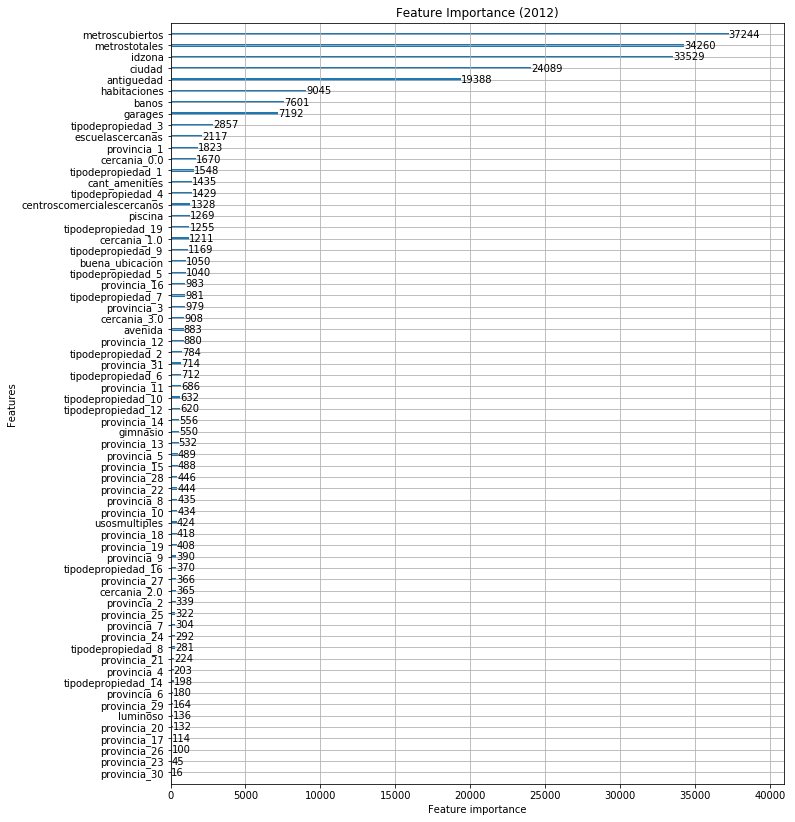

In [216]:
lightgbm.plot_importance(lgbm_2012, figsize=(11,14), title='Feature Importance (2012)')

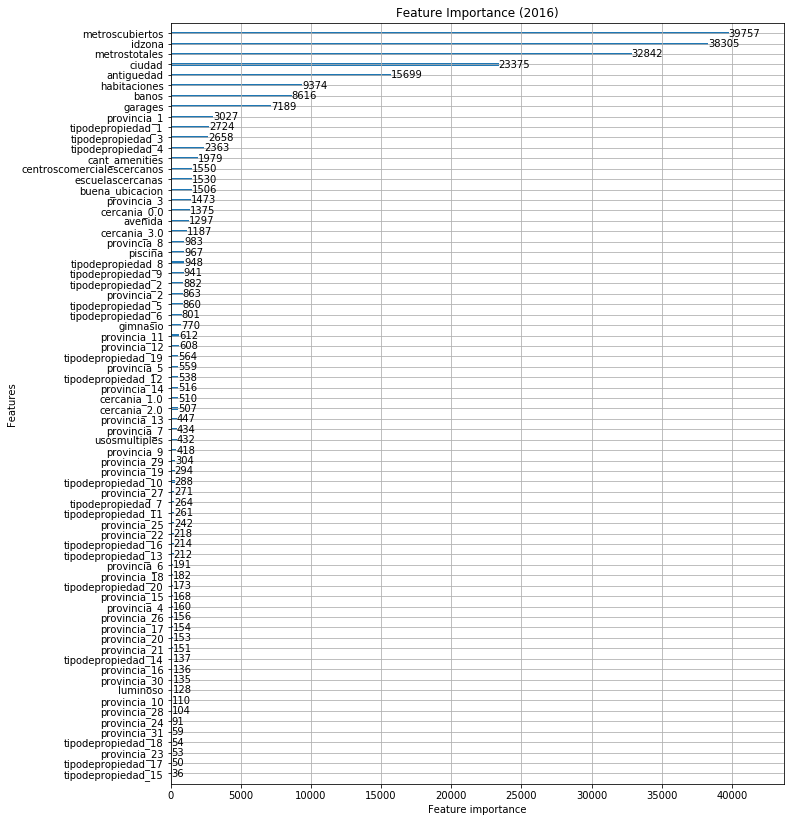

In [215]:
lightgbm.plot_importance(lgbm_2016, figsize=(11,14), title='Feature Importance (2016)')

## XGBoost

### Tuneo de hiperparámetros

In [136]:
import xgboost as xgb

dtrain_2012 = xgb.DMatrix(x_2012, label=y_2012)
dtrain_2013 = xgb.DMatrix(x_2013, label=y_2013)
dtrain_2014 = xgb.DMatrix(x_2014, label=y_2014)
dtrain_2015 = xgb.DMatrix(x_2015, label=y_2015)
dtrain_2016 = xgb.DMatrix(x_2016, label=y_2016)

/usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.5/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [137]:
def xgb_evaluate(max_depth, gamma, colsample_bytree,seed,min_child_weight,n_estimators,
                  reg_alpha,reg_lambda,subsample,learning_rate):
    params = {'eval_metric': 'rmse',
              'max_depth': int(max_depth),
              'subsample': subsample,
              'eta': 0.1,
              'gamma': gamma,
              'colsample_bytree': colsample_bytree,
              "seed": int(seed),
              "min_child_weight": min_child_weight,
              "n_estimators": n_estimators,
              "reg_alpha": reg_alpha,
              "reg_lambda": reg_lambda,
              "learning_rate": learning_rate
             }
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=100, nfold=5)    
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [138]:
def optimize(sett):
    dtrain = sett
    xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 7), 
                                             'gamma': (0, 1),
                                             'colsample_bytree': (0.3, 0.9),
                                             "seed": (10,50),
                                             "min_child_weight": (0.4,1.5),
                                             "n_estimators":(1000,10000),                                                                    
                                             "reg_alpha":(0.2,0.75),
                                             "reg_lambda": (0.2,0.8),
                                             "subsample" : (0.3, 0.8),
                                             "learning_rate": (0.01,0.07),
                                            })
    # Se probo con 3 puntos iniciales y 10 iteraciones, deberiamos probar con mas en ambas
    # La prox iteracion en casa probar 100 y 10000
    xgb_bo.maximize(init_points=5, n_iter=30, acq='ei')
    params = xgb_bo.max['params']
    params['max_depth'] = int(params['max_depth'])
    params["seed"] = int(params["seed"])
    params["n_estimators"] = int(params["n_estimators"])
    return params

In [139]:
dtrain = dtrain_2012
params_2012 = optimize(dtrain_2012)
dtrain = dtrain_2013
params_2013 = optimize(dtrain_2013)
dtrain = dtrain_2014
params_2014 = optimize(dtrain_2014)
dtrain = dtrain_2015
params_2015 = optimize(dtrain_2015)
dtrain = dtrain_2016
params_2016 = optimize(dtrain_2016)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... |   seed    | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -9.799e+0 |  0.33     |  0.6134   |  0.04418  |  3.388    |  0.7952   |  1.21e+03 |  0.6069   |  0.3696   |  37.06    |  0.3381   |
|  2        | -1.169e+0 |  0.6036   |  0.8619   |  0.01395  |  5.272    |  0.5719   |  9.46e+03 |  0.2907   |  0.5295   |  24.83    |  0.5911   |
|  3        | -8.893e+0 |  0.5075   |  0.2933   |  0.05577  |  4.516    |  1.281    |  4.505e+0 |  0.3232   |  0.5933   |  44.7     |  0.5866   |
|  4        | -8.547e+0 |  0.8566   |  0.9724   |  0.05677  |  5.618    |  1.498    |  9.382e+0 |  0.4157   |  0.6381   |  32.88    |  0.72     |
|  5        | -9.603e+0 |  0.4696   |  0.6594   |  0.02955  |  4.711    |  0.6405   |  4.666e+0 |  0.2144   |  0.3206   |  2

|  34       | -1.213e+0 |  0.8422   |  0.9059   |  0.01544  |  3.324    |  0.7214   |  1.753e+0 |  0.376    |  0.2301   |  22.93    |  0.7682   |
|  35       | -8.363e+0 |  0.8621   |  0.000184 |  0.06903  |  6.415    |  0.9722   |  8.96e+03 |  0.7493   |  0.4027   |  43.32    |  0.5498   |
|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... |   seed    | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -1.514e+0 |  0.3258   |  0.301    |  0.01031  |  3.174    |  0.9539   |  5.301e+0 |  0.4046   |  0.4079   |  15.26    |  0.3511   |
|  2        | -9.141e+0 |  0.4652   |  0.619    |  0.05894  |  3.917    |  1.062    |  9.616e+0 |  0.7203   |  0.5882   |  40.17    |  0.4186   |
|  3        | -8.391e+0 |  0.7253   |  0.7629   |  0.05355  |  5.725    |  1.152    |  1.813e+0 |  0.6543   |  0.7341   |  2

|  31       | -9.256e+0 |  0.6106   |  0.5236   |  0.04801  |  3.783    |  0.8867   |  2.602e+0 |  0.5176   |  0.3084   |  41.58    |  0.3714   |
|  32       | -9.258e+0 |  0.5057   |  0.1809   |  0.02544  |  5.649    |  1.413    |  9.24e+03 |  0.3045   |  0.3904   |  29.32    |  0.514    |
|  33       | -9.156e+0 |  0.3855   |  0.2763   |  0.06438  |  3.674    |  0.5347   |  6.453e+0 |  0.3101   |  0.5107   |  35.45    |  0.6567   |
|  34       | -9.797e+0 |  0.3609   |  0.981    |  0.03504  |  3.806    |  1.223    |  4.365e+0 |  0.5839   |  0.2792   |  40.22    |  0.5477   |
|  35       | -9.03e+05 |  0.6866   |  0.9159   |  0.06307  |  3.933    |  0.8697   |  3.118e+0 |  0.3321   |  0.6944   |  15.6     |  0.3444   |
|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... |   seed    | subsample |
----------------------------------------------------------------------------------------------------------------------------

|  28       | -1.476e+0 |  0.626    |  0.7546   |  0.01156  |  4.392    |  1.224    |  6.687e+0 |  0.5905   |  0.723    |  47.15    |  0.794    |
|  29       | -9.142e+0 |  0.6628   |  0.002656 |  0.06633  |  6.68     |  1.338    |  5.166e+0 |  0.5872   |  0.474    |  19.6     |  0.5989   |
|  30       | -1.037e+0 |  0.4712   |  0.2619   |  0.05231  |  3.508    |  0.9434   |  7.083e+0 |  0.3728   |  0.4555   |  26.63    |  0.6674   |
|  31       | -1.036e+0 |  0.661    |  0.5199   |  0.04926  |  3.038    |  0.7764   |  1.824e+0 |  0.4262   |  0.5909   |  44.36    |  0.7205   |
|  32       | -1.019e+0 |  0.5049   |  0.115    |  0.06283  |  3.352    |  0.9651   |  9.449e+0 |  0.4317   |  0.2304   |  41.04    |  0.4966   |
|  33       | -9.43e+05 |  0.7439   |  0.4285   |  0.0374   |  6.007    |  0.5914   |  1.108e+0 |  0.3453   |  0.3414   |  24.28    |  0.3982   |
|  34       | -1.017e+0 |  0.513    |  0.00957  |  0.06883  |  3.179    |  0.8616   |  7.046e+0 |  0.6424   |  0.2549   |  1

|  25       | -9.89e+05 |  0.6347   |  0.8975   |  0.03869  |  6.462    |  0.4468   |  3.183e+0 |  0.5279   |  0.6201   |  16.96    |  0.6738   |
|  26       | -1.423e+0 |  0.5879   |  0.2565   |  0.01668  |  3.828    |  0.7494   |  9.168e+0 |  0.6896   |  0.3265   |  43.59    |  0.6099   |
|  27       | -1.04e+06 |  0.83     |  0.4012   |  0.04845  |  4.115    |  1.432    |  3.419e+0 |  0.7473   |  0.7367   |  48.04    |  0.4922   |
|  28       | -9.984e+0 |  0.3584   |  0.7111   |  0.04886  |  6.799    |  0.5711   |  9.91e+03 |  0.6735   |  0.3839   |  48.52    |  0.4528   |
|  29       | -1.149e+0 |  0.3218   |  0.1915   |  0.02683  |  5.874    |  1.495    |  3.549e+0 |  0.538    |  0.7285   |  35.43    |  0.6004   |
|  30       | -9.87e+05 |  0.6213   |  0.3266   |  0.06197  |  5.061    |  0.5473   |  9.218e+0 |  0.7005   |  0.6207   |  15.54    |  0.4619   |
|  31       | -1.026e+0 |  0.4338   |  0.06392  |  0.06569  |  4.106    |  0.8056   |  8.34e+03 |  0.2473   |  0.3109   |  1

|  22       | -1.201e+0 |  0.6057   |  0.8759   |  0.04654  |  3.291    |  1.472    |  8.458e+0 |  0.4841   |  0.5775   |  38.45    |  0.5372   |
|  23       | -1.034e+0 |  0.6537   |  0.7161   |  0.06311  |  6.249    |  1.301    |  2.836e+0 |  0.3031   |  0.2388   |  24.98    |  0.4471   |
|  24       | -1.183e+0 |  0.7785   |  0.01139  |  0.03286  |  4.834    |  1.13     |  3.069e+0 |  0.4318   |  0.2395   |  37.91    |  0.7445   |
|  25       | -1.034e+0 |  0.5858   |  0.7602   |  0.06276  |  6.686    |  1.443    |  1.257e+0 |  0.532    |  0.7023   |  23.04    |  0.7581   |
|  26       | -1.176e+0 |  0.5205   |  0.5936   |  0.05772  |  3.363    |  0.6131   |  2.148e+0 |  0.6591   |  0.4763   |  48.38    |  0.4295   |
|  27       | -1.225e+0 |  0.6038   |  0.4153   |  0.04053  |  3.393    |  0.412    |  2.625e+0 |  0.3473   |  0.4176   |  35.25    |  0.5101   |
|  28       | -1.053e+0 |  0.4189   |  0.7089   |  0.06161  |  6.023    |  1.442    |  7.155e+0 |  0.3842   |  0.5817   |  3

### Probando

In [140]:
def fabrica_XGB(params):
    best_xgb_model = XGBRegressor(colsample_bytree=params["colsample_bytree"],
                 gamma=params["gamma"],                 
                 learning_rate=params["learning_rate"],
                 max_depth=params["max_depth"],
                 min_child_weight=params["min_child_weight"],
                 n_estimators=params["n_estimators"],                                                                    
                 reg_alpha=params["reg_alpha"],
                 reg_lambda=params["reg_lambda"],
                 subsample=params["subsample"],
                 seed=params["seed"])
    
    return best_xgb_model

In [141]:
XGB_2012 = fabrica_XGB(params_2012)
XGB_2013 = fabrica_XGB(params_2013)
XGB_2014 = fabrica_XGB(params_2014)
XGB_2015 = fabrica_XGB(params_2015)
XGB_2016 = fabrica_XGB(params_2016)

In [142]:
XGB_2012.fit(x_2012,y_2012)
XGB_pred_val = XGB_2012.predict(x_2012_val)
XGB_mae = MAE(y_2012_val, XGB_pred_val)
print("MAE XGB: " + str(XGB_mae))

/usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.5/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[09:16:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE XGB: 43567.16273209127


In [143]:
XGB_2013.fit(x_2013,y_2013)
XGB_pred_val = XGB_2013.predict(x_2013_val)
XGB_mae = MAE(y_2013_val, XGB_pred_val)
print("MAE XGB: " + str(XGB_mae))

[09:28:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE XGB: 81822.89305811505


In [144]:
XGB_2014.fit(x_2014,y_2014)
XGB_pred_val = XGB_2014.predict(x_2014_val)
XGB_mae = MAE(y_2014_val, XGB_pred_val)
print("MAE XGB: " + str(XGB_mae))

[09:39:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE XGB: 185198.6652709997


In [145]:
XGB_2015.fit(x_2015,y_2015)
XGB_pred_val = XGB_2015.predict(x_2015_val)
XGB_mae = MAE(y_2015_val, XGB_pred_val)
print("MAE XGB: " + str(XGB_mae))

[09:47:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE XGB: 313417.72488774237


In [146]:
XGB_2016.fit(x_2016,y_2016)
XGB_pred_val = XGB_2016.predict(x_2016_val)
XGB_mae = MAE(y_2016_val, XGB_pred_val)
print("MAE XGB: " + str(XGB_mae))

[09:52:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE XGB: 477785.6354546602


In [147]:
print(params_2012)

{'reg_alpha': 0.7492613379332995, 'subsample': 0.549819547636903, 'learning_rate': 0.06902992131997886, 'reg_lambda': 0.4026904141760629, 'n_estimators': 8959, 'gamma': 0.0001848966185690193, 'max_depth': 6, 'colsample_bytree': 0.8620504809076188, 'min_child_weight': 0.972238560837862, 'seed': 43}


In [148]:
print(params_2013)

{'reg_alpha': 0.3398912503161785, 'subsample': 0.6154682173990349, 'learning_rate': 0.05490288395872875, 'reg_lambda': 0.2873771021668522, 'n_estimators': 7821, 'gamma': 0.787421721969423, 'max_depth': 6, 'colsample_bytree': 0.6988824677203593, 'min_child_weight': 0.7655660848020114, 'seed': 12}


#### Feature Importance

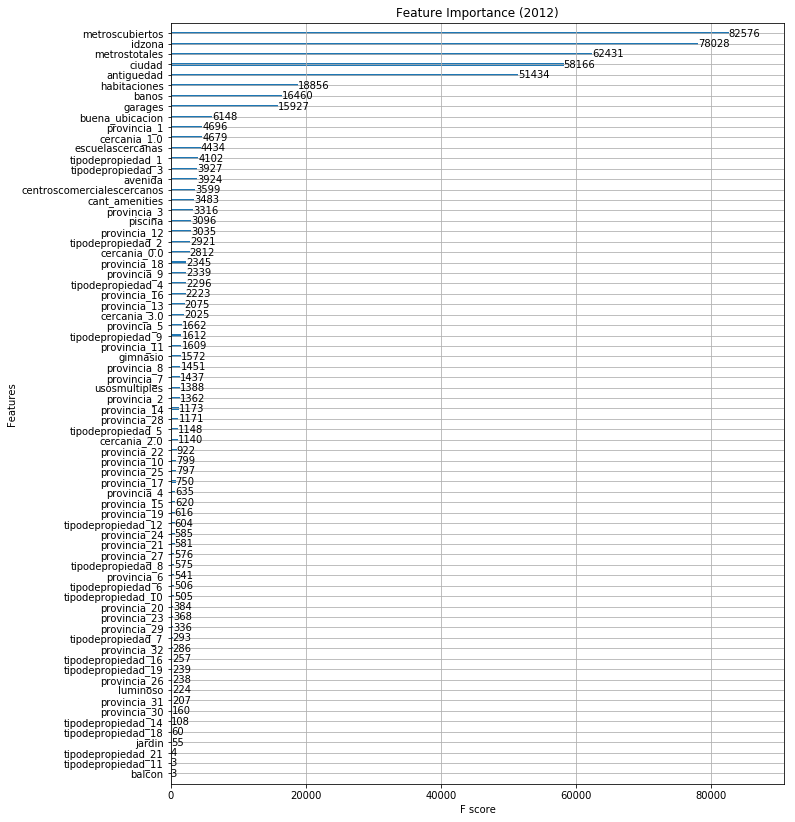

In [229]:
fig, ax = plt.subplots(1,1,figsize=(11,14))
xgb.plot_importance(XGB_2012, ax=ax, title='Feature Importance (2012)');

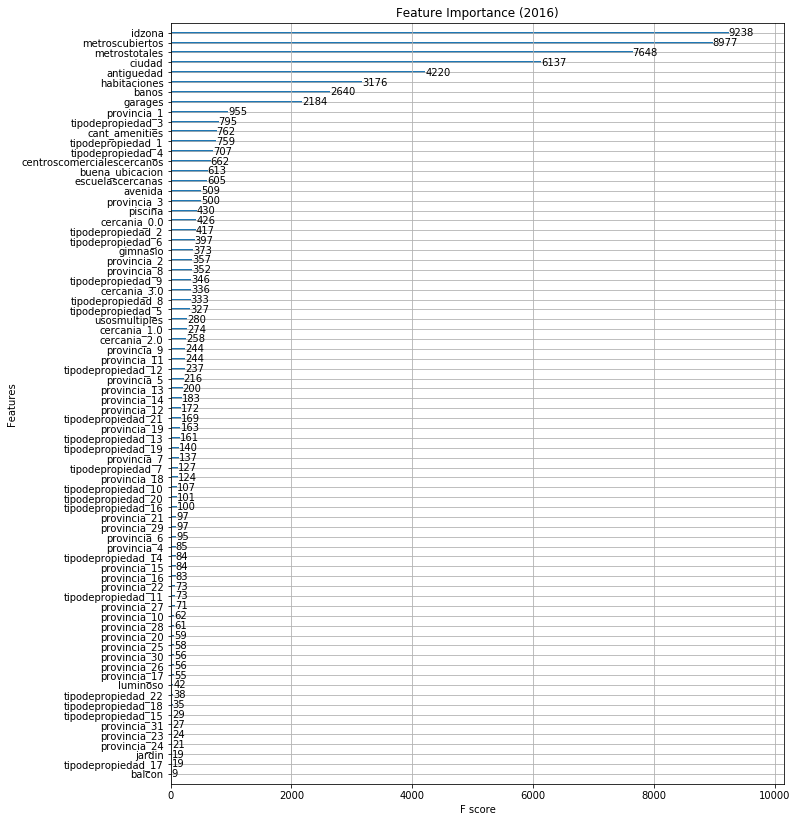

In [230]:
fig, ax = plt.subplots(1,1,figsize=(11,14))
xgb.plot_importance(XGB_2016, ax=ax, title='Feature Importance (2016)');

In [149]:
dump(XGB_2012,'XGB_2012.joblib')
dump(XGB_2013,'XGB_2013.joblib')
dump(XGB_2014,'XGB_2014.joblib')
dump(XGB_2015,'XGB_2015.joblib')
dump(XGB_2016,'XGB_2016.joblib')

['XGB_2016.joblib']

## Random Forest

In [150]:
def fabrica_RF(train, param_grid):
    RF = RandomForestRegressor()
    X = train.drop(['precio'], axis=1)
    y = train['precio']
    grid = RandomizedSearchCV(RF, param_grid, cv=4, scoring='neg_mean_absolute_error')
    grid.fit(X, y)
    RF = grid.best_estimator_
    print(grid.best_params_)
    print(grid.best_score_)
    return RF

In [151]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': ["auto"],
    "random_state" : [42],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 400]    
}

In [152]:
rf_2012 = fabrica_RF(train_2012, param_grid)
rf_2013 = fabrica_RF(train_2013, param_grid)
rf_2014 = fabrica_RF(train_2014, param_grid)
rf_2015 = fabrica_RF(train_2015, param_grid)
rf_2016 = fabrica_RF(train_2016, param_grid)

{'n_estimators': 300, 'max_features': 'auto', 'min_samples_leaf': 3, 'max_depth': 80, 'bootstrap': True, 'min_samples_split': 8, 'random_state': 42}
-466700.37794187496
{'n_estimators': 400, 'max_features': 'auto', 'min_samples_leaf': 3, 'max_depth': 110, 'bootstrap': True, 'min_samples_split': 10, 'random_state': 42}
-459819.2504903971
{'n_estimators': 200, 'max_features': 'auto', 'min_samples_leaf': 3, 'max_depth': 100, 'bootstrap': True, 'min_samples_split': 8, 'random_state': 42}
-523897.9070279283
{'n_estimators': 400, 'max_features': 'auto', 'min_samples_leaf': 4, 'max_depth': 100, 'bootstrap': True, 'min_samples_split': 8, 'random_state': 42}
-558125.3993231788
{'n_estimators': 200, 'max_features': 'auto', 'min_samples_leaf': 3, 'max_depth': 90, 'bootstrap': True, 'min_samples_split': 8, 'random_state': 42}
-592489.7235227098


In [220]:
feature_list = list(x_2012.columns)
importances = list(rf_2012.feature_importances_)
feature_importances = [(feature, importance) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]


Variable: metroscubiertos      Importance: 0.4404171006751725
Variable: idzona               Importance: 0.20573479951401533
Variable: ciudad               Importance: 0.12662915531660612
Variable: metrostotales        Importance: 0.06251884264771077
Variable: tipodepropiedad_4    Importance: 0.032395710579038006
Variable: antiguedad           Importance: 0.024767870438157813
Variable: banos                Importance: 0.01842008515008617
Variable: provincia_1          Importance: 0.013792958774243401
Variable: habitaciones         Importance: 0.011508326714029925
Variable: tipodepropiedad_9    Importance: 0.0113684778058287
Variable: garages              Importance: 0.00904703072520819
Variable: tipodepropiedad_1    Importance: 0.005179566035901908
Variable: tipodepropiedad_3    Importance: 0.005024451659686906
Variable: provincia_3          Importance: 0.004757281335392912
Variable: cant_amenities       Importance: 0.0026534101289015107
Variable: provincia_16         Importance: 0.002

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

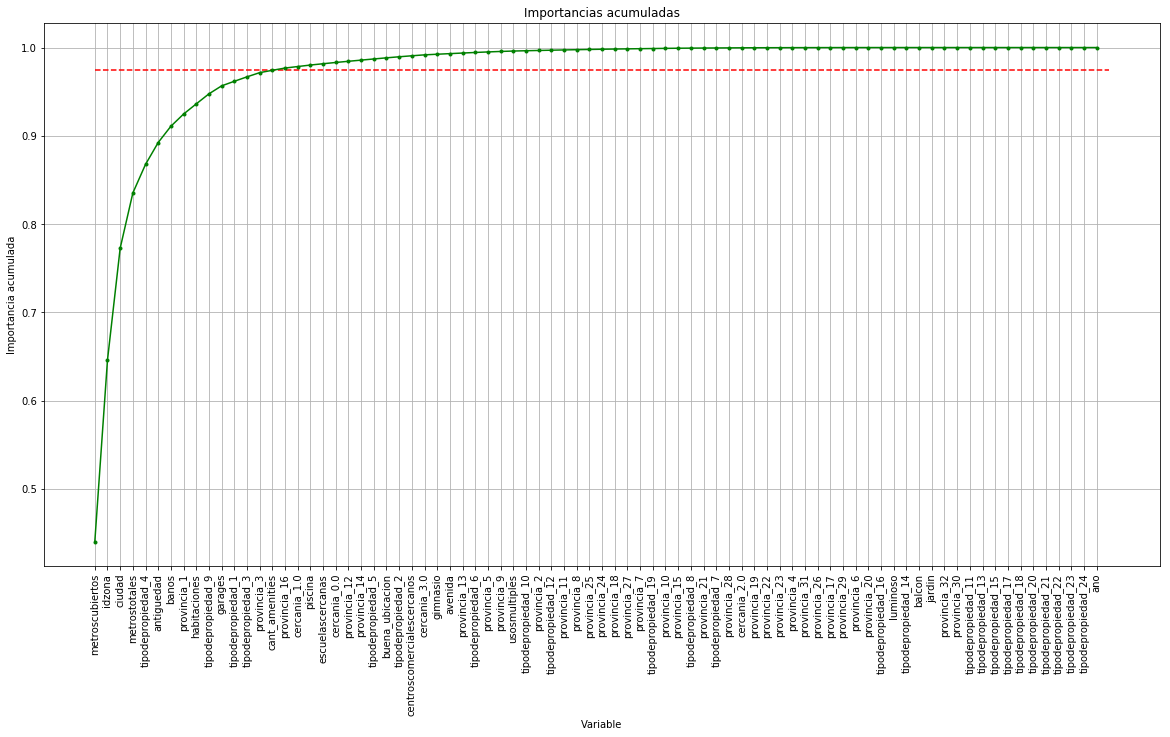

In [224]:
x_values = list(range(len(importances)))
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
cumulative_importances = np.cumsum(sorted_importances)
plt.figure(figsize=(20,10)) 
plt.plot(x_values, cumulative_importances, 'g.-')
plt.grid(True)
plt.hlines(y = 0.975, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
plt.xticks(x_values, sorted_features, rotation = 'vertical')
plt.xlabel('Variable'); plt.ylabel('Importancia acumulada'); plt.title('Importancias acumuladas');

In [227]:
feature_list = list(x_2016.columns)
importances = list(rf_2016.feature_importances_)
feature_importances = [(feature, importance) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]


Variable: idzona               Importance: 0.5468675826646866
Variable: metroscubiertos      Importance: 0.20120288205224832
Variable: metrostotales        Importance: 0.05414543390043118
Variable: ciudad               Importance: 0.051988147555562206
Variable: antiguedad           Importance: 0.025397374929791564
Variable: provincia_1          Importance: 0.016216504658270525
Variable: banos                Importance: 0.014186513384864987
Variable: habitaciones         Importance: 0.013409004542515198
Variable: tipodepropiedad_4    Importance: 0.012272834260715189
Variable: tipodepropiedad_1    Importance: 0.012070541967265022
Variable: garages              Importance: 0.009070211234840059
Variable: tipodepropiedad_3    Importance: 0.005885063958801577
Variable: tipodepropiedad_9    Importance: 0.005686205585395062
Variable: cant_amenities       Importance: 0.003246881969887803
Variable: provincia_3          Importance: 0.0023542066212873802
Variable: tipodepropiedad_5    Importance: 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

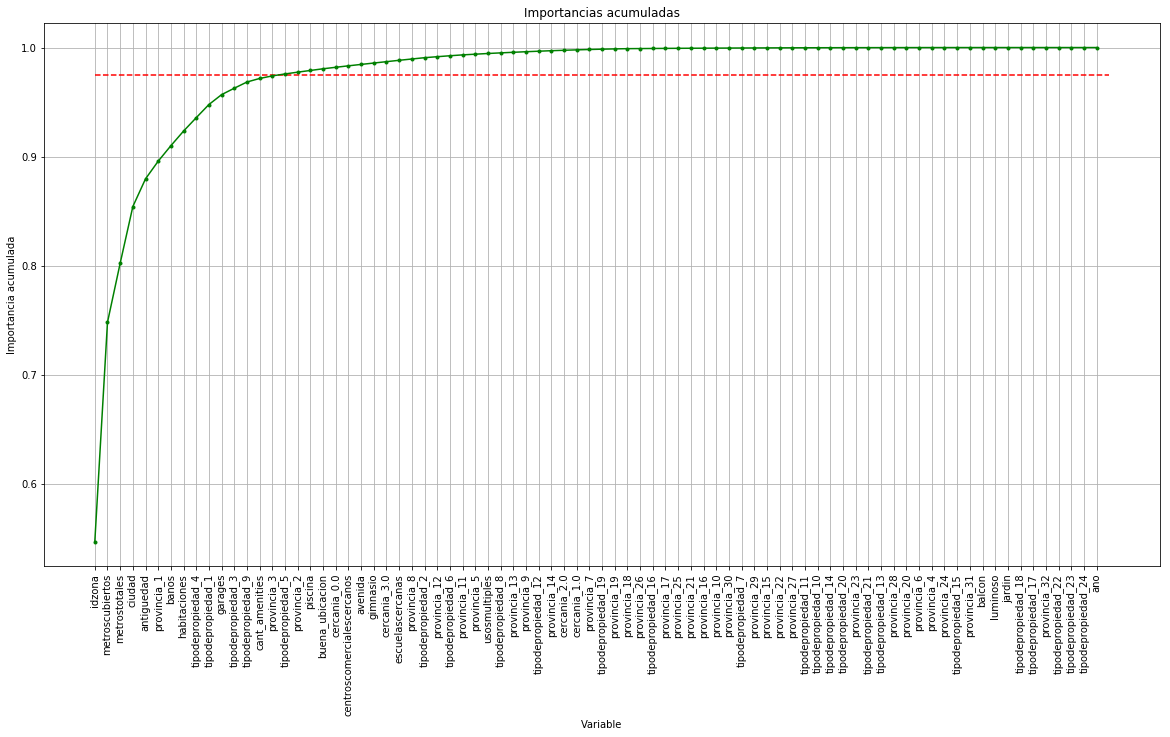

In [228]:
x_values = list(range(len(importances)))
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
cumulative_importances = np.cumsum(sorted_importances)
plt.figure(figsize=(20,10)) 
plt.plot(x_values, cumulative_importances, 'g.-')
plt.grid(True)
plt.hlines(y = 0.975, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
plt.xticks(x_values, sorted_features, rotation = 'vertical')
plt.xlabel('Variable'); plt.ylabel('Importancia acumulada'); plt.title('Importancias acumuladas');

In [156]:
dump(rf_2012,'rf_2012.joblib')
dump(rf_2013,'rf_2013.joblib')
dump(rf_2014,'rf_2014.joblib')
dump(rf_2015,'rf_2015.joblib')
dump(rf_2016,'rf_2016.joblib')

['rf_2016.joblib']

In [ ]:
#rf_2012 = RandomForestRegressor(n_estimators=200)
rf_2012.fit(x_2012,y_2012)
rf_pred_val = rf_2012.predict(x_2012_val)
rf_mae = MAE(y_2012_val, rf_pred_val)
print("MAE rf: " + str(rf_mae))

In [ ]:
#rf_2013 = RandomForestRegressor(n_estimators=200)
rf_2013.fit(x_2013,y_2013)
rf_pred_val = rf_2013.predict(x_2013_val)
rf_mae = MAE(ys_2013_val, rf_pred_val)
print("MAE rf: " + str(rf_mae))

In [ ]:
#rf_2014 = RandomForestRegressor(n_estimators=200)
rf_2014.fit(x_2014,y_2014)
rf_pred_val = rf_2014.predict(x_2014_val)
rf_mae = MAE(ys_2014_val, rf_pred_val)
print("MAE rf: " + str(rf_mae))

In [ ]:
#rf_2015 = RandomForestRegressor(n_estimators=200)
rf_2015.fit(x_2015,y_2015)
rf_pred_val = rf_2015.predict(x_2015_val)
rf_mae = MAE(ys_2015_val, rf_pred_val)
print("MAE rf: " + str(rf_mae))

In [ ]:
#rf_2016 = RandomForestRegressor(n_estimators=200)
rf_2016.fit(x_2016,y_2016)
rf_pred_val = rf_2016.predict(x_2016_val)
rf_mae = MAE(ys_2016_val, rf_pred_val)
print("MAE rf: " + str(rf_mae))

In [ ]:
#res_2012 = rf_2012.predict(test_2012)
#res_2013 = rf_2013.predict(test_2013)
#res_2014 = rf_2014.predict(test_2014)
#res_2015 = rf_2015.predict(test_2015)
#res_2016 = rf_2016.predict(test_2016)

## Ensembles

#### Voting Ensemble

In [159]:
ensemble2012 = VotingRegressor([('rf', rf_2012), ('xgb', XGB_2012),('lgbm', lgbm_2012)])
ensemble2013 = VotingRegressor([('rf', rf_2013), ('xgb', XGB_2013),('lgbm', lgbm_2013)])
ensemble2014 = VotingRegressor([('rf', rf_2014), ('xgb', XGB_2014),('lgbm', lgbm_2014)])
ensemble2015 = VotingRegressor([('rf', rf_2015), ('xgb', XGB_2015),('lgbm', lgbm_2015)])
ensemble2016 = VotingRegressor([('rf', rf_2016), ('xgb', XGB_2016),('lgbm', lgbm_2016)])

In [160]:
ensemble2012.fit(x_2012, y_2012)
en_pred_val = ensemble2012.predict(x_2012_val)
en_mae = MAE(y_2012_val, en_pred_val)
print("MAE Ensemble: " + str(en_mae))

/usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.5/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:09:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE Ensemble: 179683.2099947171


In [161]:
ensemble2013.fit(x_2013, y_2013)
en_pred_val = ensemble2013.predict(x_2013_val)
en_mae = MAE(y_2013_val, en_pred_val)
print("MAE Ensemble: " + str(en_mae))

/usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.5/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:23:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE Ensemble: 195935.97013991393


In [162]:
ensemble2014.fit(x_2014, y_2014)
en_pred_val = ensemble2014.predict(x_2014_val)
en_mae = MAE(y_2014_val, en_pred_val)
print("MAE Ensemble: " + str(en_mae))

/usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.5/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:36:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE Ensemble: 260153.16893060366


In [163]:
ensemble2015.fit(x_2015, y_2015)
en_pred_val = ensemble2015.predict(x_2015_val)
en_mae = MAE(y_2015_val, en_pred_val)
print("MAE Ensemble: " + str(en_mae))

/usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.5/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:46:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE Ensemble: 345451.5400176705


In [164]:
ensemble2016.fit(x_2016, y_2016)
en_pred_val = ensemble2016.predict(x_2016_val)
en_mae = MAE(y_2016_val, en_pred_val)
print("MAE Ensemble: " + str(en_mae))

/usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.5/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:55:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE Ensemble: 418660.70419734233


In [167]:
dump(ensemble2012,'votens2012.joblib')
dump(ensemble2013,'votens2013.joblib')
dump(ensemble2014,'votens2014.joblib')
dump(ensemble2015,'votens2015.joblib')
dump(ensemble2016,'votens2016.joblib')

['votens2016.joblib']

In [169]:
res_2012 = ensemble2012.predict(test_2012)
res_2013 = ensemble2013.predict(test_2013)
res_2014 = ensemble2014.predict(test_2014)
res_2015 = ensemble2015.predict(test_2015)
res_2016 = ensemble2016.predict(test_2016)

In [170]:
res_2012 = pd.DataFrame(res_2012, index=test_2012.index, columns=['precio'])
res_2012 = res_2012.rename(columns={'precio':'target'})

res_2013 = pd.DataFrame(res_2013, index=test_2013.index, columns=['precio'])
res_2013 = res_2013.rename(columns={'precio':'target'})

res_2014 = pd.DataFrame(res_2014, index=test_2014.index, columns=['precio'])
res_2014 = res_2014.rename(columns={'precio':'target'})

res_2015 = pd.DataFrame(res_2015, index=test_2015.index, columns=['precio'])
res_2015 = res_2015.rename(columns={'precio':'target'})

res_2016 = pd.DataFrame(res_2016, index=test_2016.index, columns=['precio'])
res_2016 = res_2016.rename(columns={'precio':'target'})

In [171]:
res = res_2012.append(res_2013).append(res_2014).append(res_2015).append(res_2016)
res.to_csv("workshop-submission-vot-ens.csv", header=True)

#### Stacking Ensemble

In [186]:
from mlxtend.regressor import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [202]:
stack_2012 = StackingRegressor(regressors=[lgbm_2012, XGB_2012, rf_2012]
                                , meta_regressor=GradientBoostingRegressor())
stack_2012.fit(x_2012, y_2012)
en_pred_val = stack_2012.predict(x_2012_val)
en_mae = MAE(y_2012_val, en_pred_val)
print("MAE Ensemble: " + str(en_mae))

/usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.5/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[15:39:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE Ensemble: 40925.3190673712


In [203]:
stack_2013 = StackingRegressor(regressors=[lgbm_2013, XGB_2013, rf_2013]
                                , meta_regressor=GradientBoostingRegressor())
stack_2013.fit(x_2013, y_2013)
en_pred_val = stack_2013.predict(x_2013_val)
en_mae = MAE(y_2013_val, en_pred_val)
print("MAE Ensemble: " + str(en_mae))

/usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.5/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[15:53:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE Ensemble: 72958.39073285703


In [204]:
stack_2014 = StackingRegressor(regressors=[lgbm_2014, XGB_2014, rf_2014]
                                , meta_regressor=GradientBoostingRegressor())
stack_2014.fit(x_2014, y_2014)
en_pred_val = stack_2014.predict(x_2014_val)
en_mae = MAE(y_2014_val, en_pred_val)
print("MAE Ensemble: " + str(en_mae))

/usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.5/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:08:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE Ensemble: 159636.86869991553


In [205]:
stack_2015 = StackingRegressor(regressors=[lgbm_2015, XGB_2015, rf_2015]
                                , meta_regressor=GradientBoostingRegressor())
stack_2015.fit(x_2015, y_2015)
en_pred_val = stack_2015.predict(x_2015_val)
en_mae = MAE(y_2015_val, en_pred_val)
print("MAE Ensemble: " + str(en_mae))

/usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.5/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:19:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE Ensemble: 261428.5308243153


In [206]:
stack_2016 = StackingRegressor(regressors=[lgbm_2016, XGB_2016, rf_2016]
                                , meta_regressor=GradientBoostingRegressor())
stack_2016.fit(x_2016, y_2016)
en_pred_val = stack_2016.predict(x_2016_val)
en_mae = MAE(y_2016_val, en_pred_val)
print("MAE Ensemble: " + str(en_mae))

/usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.5/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:29:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE Ensemble: 337383.5702457113


In [194]:
dump(stack_2012,'stackens2012.joblib')
dump(stack_2013,'stackens2013.joblib')
dump(stack_2014,'stackens2014.joblib')
dump(stack_2015,'stackens2015.joblib')
dump(stack_2016,'stackens2016.joblib')

['stackens2016.joblib']

In [207]:
stack_res_2012 = stack_2012.predict(test_2012)
stack_res_2013 = stack_2013.predict(test_2013)
stack_res_2014 = stack_2014.predict(test_2014)
stack_res_2015 = stack_2015.predict(test_2015)
stack_res_2016 = stack_2016.predict(test_2016)

In [208]:
stack_res_2012 = pd.DataFrame(stack_res_2012, index=test_2012.index, columns=['precio'])
stack_res_2012 = stack_res_2012.rename(columns={'precio':'target'})

stack_res_2013 = pd.DataFrame(stack_res_2013, index=test_2013.index, columns=['precio'])
stack_res_2013 = stack_res_2013.rename(columns={'precio':'target'})

stack_res_2014 = pd.DataFrame(stack_res_2014, index=test_2014.index, columns=['precio'])
stack_res_2014 = stack_res_2014.rename(columns={'precio':'target'})

stack_res_2015 = pd.DataFrame(stack_res_2015, index=test_2015.index, columns=['precio'])
stack_res_2015 = stack_res_2015.rename(columns={'precio':'target'})

stack_res_2016 = pd.DataFrame(stack_res_2016, index=test_2016.index, columns=['precio'])
stack_res_2016 = stack_res_2016.rename(columns={'precio':'target'})

In [209]:
stack_res = stack_res_2012.append(stack_res_2013).append(stack_res_2014).append(stack_res_2015).append(stack_res_2016)
stack_res.to_csv("workshop-submission-stacking.csv", header=True)

#### Voting Ensemble con KNN

In [211]:
_ensemble2012 = VotingRegressor([('rf', rf_2012), ('xgb', XGB_2012),('lgbm', lgbm_2012),('knn', KNN_2012)])
_ensemble2013 = VotingRegressor([('rf', rf_2013), ('xgb', XGB_2013),('lgbm', lgbm_2013),('knn', KNN_2013)])
_ensemble2014 = VotingRegressor([('rf', rf_2014), ('xgb', XGB_2014),('lgbm', lgbm_2014),('knn', KNN_2014)])
_ensemble2015 = VotingRegressor([('rf', rf_2015), ('xgb', XGB_2015),('lgbm', lgbm_2015),('knn', KNN_2015)])
_ensemble2016 = VotingRegressor([('rf', rf_2016), ('xgb', XGB_2016),('lgbm', lgbm_2016),('knn', KNN_2016)])

In [212]:
_ensemble2012.fit(x_2012, y_2012)
en_pred_val = _ensemble2012.predict(x_2012_val)
en_mae = MAE(y_2012_val, en_pred_val)
print("MAE Ensemble: " + str(en_mae))

/usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.5/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:42:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE Ensemble: 315710.8166733392


In [226]:
_ensemble2013.fit(x_2013, y_2013)
en_pred_val = _ensemble2013.predict(x_2013_val)
en_mae = MAE(y_2013_val, en_pred_val)
print("MAE Ensemble: " + str(en_mae))

/usr/local/lib/python3.5/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.5/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:08:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


KeyboardInterrupt: 

In [ ]:
_ensemble2014.fit(x_2014, y_2014)
en_pred_val = _ensemble2014.predict(x_2014_val)
en_mae = MAE(y_2014_val, en_pred_val)
print("MAE Ensemble: " + str(en_mae))

In [ ]:
_ensemble2015.fit(x_2015, y_2015)
en_pred_val = _ensemble2012.predict(x_2015_val)
en_mae = MAE(y_2015_val, en_pred_val)
print("MAE Ensemble: " + str(en_mae))

In [ ]:
_ensemble2016.fit(x_2016, y_2016)
en_pred_val = _ensemble2016.predict(x_2016_val)
en_mae = MAE(y_2016_val, en_pred_val)
print("MAE Ensemble: " + str(en_mae))

In [ ]:
_res_2012 = _ensemble2012.predict(test_2012)
_res_2013 = _ensemble2013.predict(test_2013)
_res_2014 = _ensemble2014.predict(test_2014)
_res_2015 = _ensemble2015.predict(test_2015)
_res_2016 = _ensemble2016.predict(test_2016)

In [ ]:
_res = _res_2012.append(_res_2013).append(_res_2014).append(_res_2015).append(_res_2016)
_res.to_csv("workshop-submission-vot-ens.csv", header=True)

#### Promedio entre voting y Stacking